In [11]:
import pandas as pd 
import numpy as np
import re
import string
import calendar
import nltk 

In [12]:
visa_experience = '/Users/churnika/Desktop/Projects/ML-Crate/F1 Visa Experiences/Dataset/telegram.csv'
visa_data = pd.read_csv(visa_experience) 

visa_data_clean = visa_data.dropna() #removing rows with missing values

visa_data_clean.describe(include='all')

,msg_id,date,message
count,6391.000000,6391,6391
unique,NaN,6372,6317
top,NaN,2021-07-01 04:30:10,Look this out for visa alerts👇\nhttps://t.me/A...
freq,NaN,2,5
mean,3384.868252,NaN,NaN
std,1908.469258,NaN,NaN
min,4.000000,NaN,NaN
25%,1768.500000,NaN,NaN
50%,3401.000000,NaN,NaN
75%,5034.500000,NaN,NaN


In [13]:
# accessing the message column and converting it into lower case

msg_exp = visa_data_clean['message'].str.lower()

In [14]:
# removing the urls that are present.

text_without_urls = []

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_without_urls = url_pattern.sub('',text)
    return text_without_urls

for i in range(len(msg_exp)):
    try:
        msg_exp[i] = remove_urls(msg_exp[i])
        text_without_urls.append(msg_exp[i])
    except KeyError as e:
        # print(f"Error at index {i}: {e}. Skipping...")
        continue


In [15]:
# removing punctuations

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

print("Length of text_without_urls:", len(text_without_urls))

for i in range(len(text_without_urls)):
    try:
        text_without_urls[i] = remove_punctuation(text_without_urls[i])

    except KeyError as e:
        print(f"Error at index {i}: {e}. Skipping...")
        continue

Length of text_without_urls: 6340


In [16]:
# TOKENIZATION
# REMOVING URLS
# REMOVING NUMBERS
# REMOVING STOP WORDS

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

months_days = [calendar.month_name[i].lower() for i in range(1, 13)] + [calendar.day_name[i].lower() for i in range(7)]
remove_words = ["vo","n","m","c","ra","xx","r","date","hii","hi","ye","pa","xxx","p","sir","mam","good","morning","time","ur","you","status","father"]

cleaned_tokens = []

for i in range(len(text_without_urls)):
    try:
        tokens = nltk.word_tokenize(text_without_urls[i])
        # Filter out URLs
        tokens = [token for token in tokens if not re.match(r'http[s]?://', token)]
        tokens = [token for token in tokens if token.isalpha()]
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [token for token in tokens if token not in months_days]
        tokens = [token for token in tokens if token not in remove_words]
        cleaned_tokens.append(tokens)
    except Exception as e:
        print(f"Error at index {i}: {e}. Skipping...")
        continue


[nltk_data] Downloading package punkt to /Users/churnika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# LEMMATIZATION

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [[lemmatizer.lemmatize(token) for token in tokens]for tokens in cleaned_tokens]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# REMOVING RARE OR FREQUENTLY USED WORDS

from collections import Counter

freq = Counter([token for tokens in lemmatized_tokens for token in tokens])
freq_threshold = 10

lemmatized_tokens = [[token for token in tokens if freq[token] > freq_threshold] for tokens in lemmatized_tokens]

In [19]:
#REMOVING WHITESPACES

cleaned_lemmatized_tokens = [' '.join(tokens) for tokens in lemmatized_tokens]
cleaned_lemmatized_tokens = [text.split() for text in cleaned_lemmatized_tokens]

In [20]:
# Dictionary mapping abbreviations to their full forms
abbreviation_dict = {
    "don't": "do not",
    "can't": "cannot",
    "u": "you",
    "approv": "approve",
    "approved": "approve",
    "rejected": "reject"
}

# Function to expand abbreviations
def expand_abbreviations(tokens):
    expanded_tokens = []
    for token in tokens:
        if token in abbreviation_dict:
            expanded_tokens.extend(abbreviation_dict[token].split())
        else:
            expanded_tokens.append(token)
    return expanded_tokens

# Expand abbreviations in cleaned_lemmatized_tokens
expanded_lemmatized_tokens = [expand_abbreviations(tokens) for tokens in cleaned_lemmatized_tokens]


In [21]:
#REMOVE ACCENTS AND DIACRITICS FROM EXPANDED_LEMMATIZED_TOKENS

from unidecode import unidecode

def remove_accents_diacritics(tokens):
    cleaned_tokens = []
    for token in tokens:
        cleaned_token = unidecode(token)
        cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

expanded_lemmatized_tokens = [remove_accents_diacritics(tokens) for tokens in expanded_lemmatized_tokens]


In [22]:
# PART-OF-SPEECH

pos_tagged_tokens = [nltk.pos_tag(tokens) for tokens in expanded_lemmatized_tokens]

In [23]:
# VECTORIZATION

from sklearn.feature_extraction.text import TfidfVectorizer

joined_tokens = [' '.join(tokens) for tokens in expanded_lemmatized_tokens]

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(joined_tokens)

In [24]:
# SENTIMENT ANALYSIS

from nltk.sentiment import SentimentIntensityAnalyzer

# Create SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Let's say we have the following tokens
tokens = expanded_lemmatized_tokens

# Function to get sentiment
def get_sentiment(token_list):
    # Join the tokens into a string
    text = ' '.join(token_list)
    # Use the polarity_scores method to get the sentiment
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply the function to each list of tokens
sentiments = [get_sentiment(token_list) for token_list in tokens]

# Now, 'sentiments' is a list of sentiment scores for each message


In [25]:
# MAPPING SENTIMENTS TO y

def map_sentiment_score_to_label(sentiment):
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Map sentiment scores to sentiment labels
sentiment_labels = [map_sentiment_score_to_label(sentiment) for sentiment in sentiments]

y = sentiment_labels


In [26]:
# SPLITTING INTO TRAINING AND TESTING

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LOGISTIC REGRESSION MODEL

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       1.00      0.20      0.33        50
     neutral       1.00      0.06      0.12        31
    positive       0.95      1.00      0.97      1187

    accuracy                           0.95      1268
   macro avg       0.98      0.42      0.48      1268
weighted avg       0.95      0.95      0.93      1268



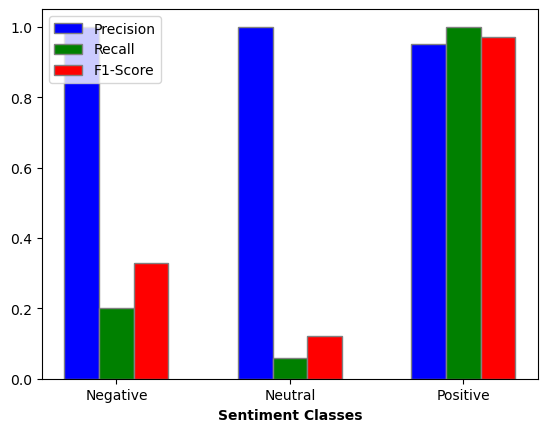

In [29]:
import matplotlib.pyplot as plt

# Define classes and corresponding metrics
classes = ['Negative', 'Neutral', 'Positive']
precision = [1.00, 1.00, 0.95]
recall = [0.20, 0.06, 1.00]
f1_score = [0.33, 0.12, 0.97]

# Set width of bar
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(precision))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(precision))], classes)

# Create legend & Show graphic
plt.legend()
plt.show()


RANDOM FOREST CLASSIFIER

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      0.16      0.28        50
     neutral       0.69      0.29      0.41        31
    positive       0.95      1.00      0.97      1187

    accuracy                           0.95      1268
   macro avg       0.88      0.48      0.55      1268
weighted avg       0.95      0.95      0.93      1268



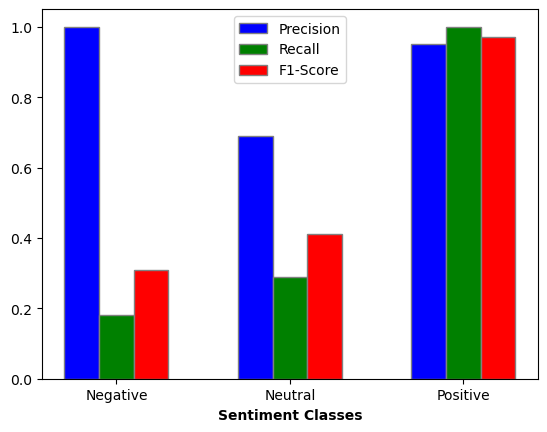

In [31]:
# Define classes and corresponding metrics
classes = ['Negative', 'Neutral', 'Positive']
precision = [1.00, 0.69, 0.95]
recall = [0.18, 0.29, 1.00]
f1_score = [0.31, 0.41, 0.97]

# Set width of bar
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(precision))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(precision))], classes)

# Create legend & Show graphic
plt.legend()
plt.show()

SUPPORT VECTOR MACHINES

In [32]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
train_predictions = svm_classifier.predict(X_train)

print("Classification Report on Training Data:")
print(classification_report(y_train, train_predictions))


Classification Report on Training Data:
              precision    recall  f1-score   support

    negative       0.99      0.58      0.73       191
     neutral       1.00      0.36      0.53        89
    positive       0.97      1.00      0.99      4792

    accuracy                           0.97      5072
   macro avg       0.99      0.65      0.75      5072
weighted avg       0.97      0.97      0.97      5072



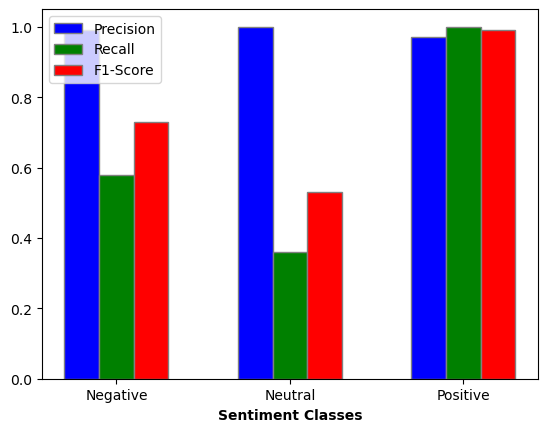

In [33]:
# Define classes and corresponding metrics
classes = ['Negative', 'Neutral', 'Positive']
precision = [0.99, 1.00, 0.97]
recall = [0.58, 0.36, 1.00]
f1_score = [0.73, 0.53, 0.99]

# Set width of bar
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(precision))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Sentiment Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(precision))], classes)

# Create legend & Show graphic
plt.legend()
plt.show()

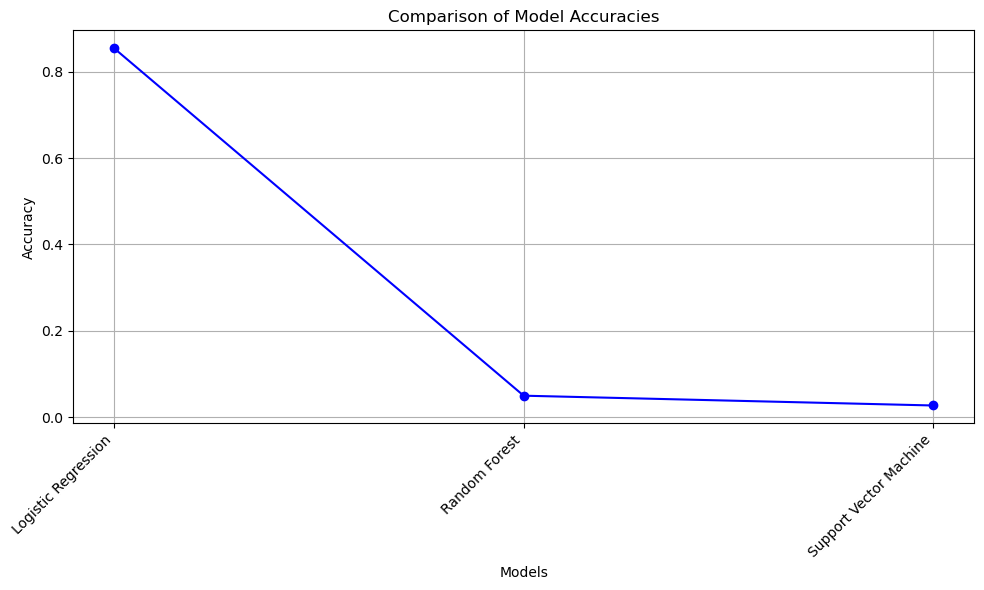

In [34]:
import matplotlib.pyplot as plt

# Define models and their corresponding accuracies
models = ['Logistic Regression', 'Random Forest', 'Support Vector Machine']
accuracies = [0.8545, 0.0496, 0.0269]  

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', color='b', linestyle='-')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
